# Capítulo 3: Classificação

## MNIST

In [1]:
# Obtendo o dataset de numéros do MNIST
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")

mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',


In [2]:
# Arrays de dados
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

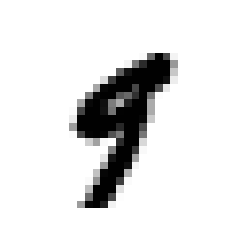

In [3]:
# Plotando um caractere
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap= matplotlib.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

In [4]:
y[36024]

'9'

In [56]:
# Separando o conjunto de treino e teste

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# FIX pois por usarmos o openMl, as labels são strings e não números
y_train = y_train.astype(np.int8)

In [57]:
# embrulhando o conjunto de treinamento

import numpy as np

shuffle_index = np.random.permutation(6000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Treinando um classificador binário

In [58]:
# Inicialmente faremos um classificador binário que trabalha somente com 5 ou não 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [59]:
# E faremos o treino com um classificador de Gradiente Descendente estocástico
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Medições de desempenho

### Utilizando validação cruzada

In [60]:
"""
Lembrando que validação cruzada K-fold significa dividir o conjunto de treinamento em K-folds ( 3 no caso abaixo),
prever e avaliar as previsões em cada conjunto utilizando um modelo treinado em conjuntos restantes.
"""

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9695, 0.959 , 0.966 ])

In [61]:
"""
Apesar de a acurácia estar alta, algo está suspeito. Façamos então um modelo que simplesmente estima "nao 5"
"""

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

never_5_clf = Never5Classifier()

"""
Como veremos abaixo, mesmo um estimador que sempre estima 'nao 5' tem uma acurácia de mais de 90%. Isso de deve ao 
fato de nosso dataset ter aproximadamente 10% de '5', o que torna a precisão do chute alta e demonstra que acurácia
pode não ser uma medida preferencial de desempenho para os classificadores.
"""
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9165, 0.9115, 0.915 ])

### Matriz de confusão

In [62]:
from sklearn.model_selection import cross_val_predict


"""
Assim como a função cross_val_score, cross_val_predict desempenha a validação cruzada K-fold, mas, em vez 
de retornar as pontuações de avaliação, ela retorna as previsões feitas em cada parte do teste 
"""
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [63]:
from sklearn.metrics import confusion_matrix

"""
Onde temos 
TN, FP
FN. TP
"""
confusion_matrix(y_train_5, y_train_pred)

array([[5397,   89],
       [ 122,  392]])

###  Precisão e revocação

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score

"""
Antes, alguns conceitos: 

Precisão: acurácia das previsões positivas;
Revocação: taxa de instâncias positivas que são corretamente detectadas 
1pelo classificador.
"""

precision_score_5 = precision_score(y_train_5, y_train_pred)
recall_score_5 = recall_score(y_train_5, y_train_pred)

print(precision_score_5,recall_score_5)

0.814968814968815 0.7626459143968871


In [65]:
"""
Pontuação F1: média harmônica entre precisão e revocação. Ela favorece classificadores com precisão e revocação
similiares, o que nem sempre é desejado.
"""

f1_score(y_train_5, y_train_pred)

0.7879396984924624

### Compensação da precisão/revocação

In [66]:
y_scores = sgd_clf.decision_function([some_digit])

print(y_scores)

threshold = 0

y_some_digit_pred = (y_scores > threshold)

print(y_some_digit_pred)

[-168543.94598278]
[False]


In [67]:
threshold = 200000

y_some_digit_pred = (y_scores > threshold)

print(y_some_digit_pred)

"""
Apesar de não ter ficado explícito aqui, aumentar o limiar diminui a revocação;
"""

[False]


'\nApesar de não ter ficado explícito aqui, aumentar o limiar diminui a revocação;\n'

In [68]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [69]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

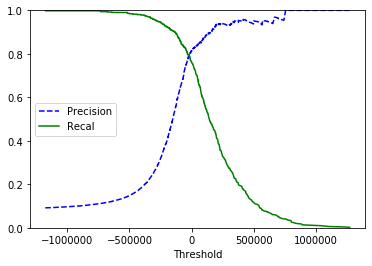

In [70]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recal')
    plt.xlabel('Threshold')
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Curva ROC

In [71]:
"""
Curva das características operacionais do receptor. A curva ROC plota a taca de verdadeiros positivos (TPR) vs 
taxa de falsos positivos (FPR). 

Onde FPR = 1 - TNR

Logo ROC = (revocação / 1- especificade)
"""

# Para plotar a curva roc primeiro é necessário calcular a TPR e FPR

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

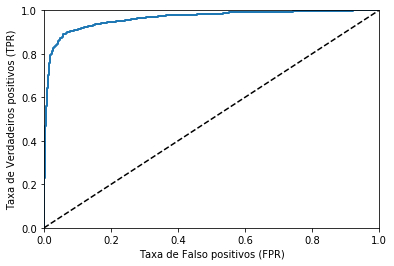

In [72]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("Taxa de Falso positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros positivos (TPR)")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [73]:
"""
Uma forma de comparar classificadores é medir a área da curva (AUC, do inglês): um classificador perfeito terá 
um ROC AUC igual a 1, enquanto um classificador puramente aleatório terá ROC AUC igual a 0,5
"""
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9633226280975556

In [74]:
"""
Podemos então comparar a curva ROC e a pontuação ROC AUC entre um RandomForestClassifier e o SGDClassifier:
"""
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


"""
Porém, para plotar uma curva ROC AUC precisamos de pontuações, não probabilidades. Uma solução simples é utilizar a
probabilidade da classe positiva como a pontuação:
"""
y_scores_forest = y_probas_forest[:,1] # onde a pontuação = probabilidade da classe positiva
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)

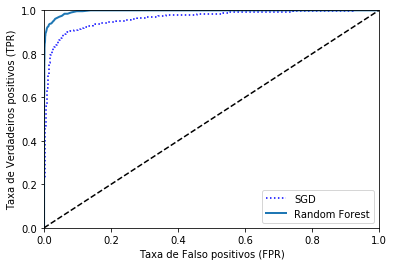

In [75]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

## Classificação multiclasse

In [76]:
"""
Estratégias de classificadores binários para lidarem com multi-classe:

One vs All (OvA): Treinar para cada possível classe um classificador binário e selecionar aquele com maior 
pontuação 

One vs One (OvO): Treinar um classificador binário para cada par de dígitos. Para N classes, precisamos treinar
N * (N-1)/2 classificadores.
"""

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([9], dtype=int8)

In [77]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-1201725.28900259,  -301756.28774699,  -975098.70740972,
          -73469.23801055,  -109658.96003006,  -139719.67688127,
         -860993.8109636 ,  -403783.55470689,  -322276.62782938,
          -47064.42390533]])

In [78]:
np.argmax(some_digit_scores)

9

In [79]:
# treinar um RandomForestClassifier:

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([4], dtype=int8)

In [80]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.03, 0.02, 0.04, 0.36, 0.07, 0.02, 0.08, 0.03, 0.35]])

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8965, 0.89  , 0.8925])

## Análise de erro

In [82]:
# Podemos verificar a matrix de confusão para plotar os erros

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[576,   0,   1,   4,   1,   3,   4,   0,   3,   0],
       [  0, 633,  10,   4,   2,   6,   0,   3,  13,   0],
       [  7,  10, 493,  17,  12,   6,   6,   7,  19,   4],
       [  2,   7,  21, 517,   0,  27,   2,  11,  11,  10],
       [  5,   5,   6,   2, 571,   1,   6,   2,   6,  19],
       [  4,   4,   6,  23,  12, 425,   9,   2,  19,  10],
       [  3,   4,  10,   0,   5,  10, 566,   3,   7,   0],
       [  3,   5,   8,   3,  10,   0,   1, 593,   3,  25],
       [  0,  16,  18,  16,   0,  18,   4,   3, 460,  16],
       [  8,   3,   4,   8,  17,   3,   0,  28,   6, 524]])

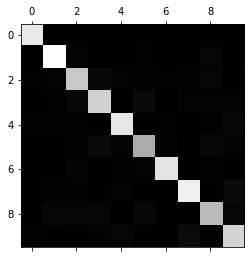

In [83]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

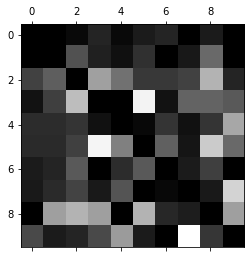

In [84]:
"""
Dividiremos cada valor na matriz pelo número de imagens correspondente para comparar taxas de erro ao invés 
de erro absoluto, o que tornaria a avaliação injusta.
"""

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Preenchemos as diagonais com 0's para manter apenas os erros e plotar o resultado:
np.fill_diagonal(norm_conf_mx, 0)


# Onde as linhas representam as classes reais, e as colunas as classes previstas
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

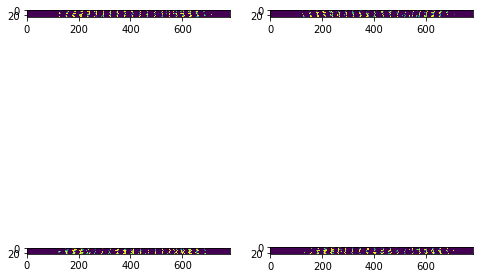

In [85]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))

plt.subplot(221); plt.imshow(X_aa[:25])
plt.subplot(222); plt.imshow(X_ab[:25])
plt.subplot(223); plt.imshow(X_ba[:25])
plt.subplot(224); plt.imshow(X_bb[:25])

plt.show()

## Classificação MultiLabel

In [86]:
#(...)

## Classificação MultiOutput

In [87]:
# Generalização da classificação multilabel em que cada rótulo pode ser multiclasse

noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test